In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
import os
from tqdm.auto import tqdm

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split



import torch
from torch import nn
import torchvision
from torchvision import datasets, models, transforms as T
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data
import torchvision.utils as vutils
from torchinfo import summary
import torch.nn.functional as F
from skimage import io

from typing import Dict, List, Tuple


This notebook aims to implement hybrid CNN models for detection of breast cancer as proposed by Sahu et al in their paper *High accuracy hybrid CNN classifiers for breast cancer detection using mammogram and ultrasound datasets*

# Initial Exploratory analysis

In [2]:
fold_info = pd.read_csv("/kaggle/input/breakhis/Folds.csv")
fold_info["label"] = fold_info["filename"].str.extract("(malignant|benign)")
fold_info['label'] = fold_info['label'].map({'malignant': 1, 'benign': 0})
fold_info[1:]

,fold,mag,grp,filename,label
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,0
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,0
3,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,0
4,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,0
5,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,0
...,...,...,...,...,...
39540,5,400,test,BreaKHis_v1/histology_slides/breast/malignant/...,1
39541,5,400,test,BreaKHis_v1/histology_slides/breast/malignant/...,1
39542,5,400,test,BreaKHis_v1/histology_slides/breast/malignant/...,1
39543,5,400,test,BreaKHis_v1/histology_slides/breast/malignant/...,1


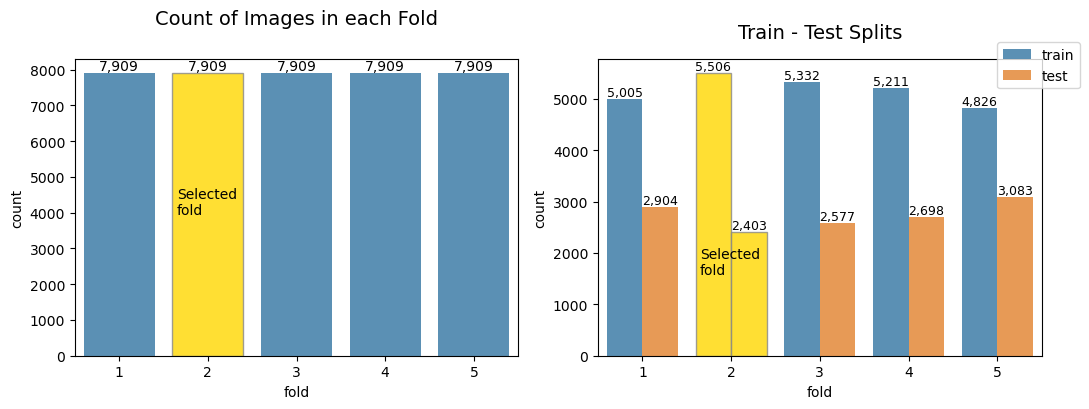

In [3]:
selected_fold = 2
selected_fold_data = fold_info.query("fold == @selected_fold").copy()
selected_fold_data["filename"] = ("/kaggle/input/breakhis/BreaKHis_v1/"
                                  + selected_fold_data["filename"])
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(11, 4.2), tight_layout=True)
# Plot image count in each fold
sns.countplot(data=fold_info, x="fold", color="C0", ax=ax1, alpha=0.8)
bars = ax1.containers[0]
ax1.bar_label(bars, padding=0,
             labels=[f"{x:,.0f}" for x in bars.datavalues])
_selected_bar = bars[selected_fold - 1]
_selected_bar.set_facecolor("gold")
_selected_bar.set_edgecolor("#888")
ax1.text(_selected_bar.get_x() + 0.05, _selected_bar.get_height() / 2,
         "Selected\nfold")
ax1.set_title("Count of Images in each Fold", size=14, pad=25)

# Plot train-test split
sns.countplot(data=fold_info, x="fold", hue="grp", palette="tab10",
              ax=ax2, alpha=0.8)
for bars in ax2.containers:
    ax2.bar_label(bars, [f"{x:,.0f}" for x in bars.datavalues], size=9)
    bars[selected_fold - 1].set_facecolor("gold")
    bars[selected_fold - 1].set_edgecolor("#888")
ax2.text(_selected_bar.get_x() + 0.05, _selected_bar.get_height() / 5,
         "Selected\nfold")
ax2.set_title("Train - Test Splits", size=14, pad=15)
ax2.legend(loc=(0.9, 0.9));

In [4]:
train = selected_fold_data.query("grp == 'train'")
test = selected_fold_data.query("grp == 'test'")
train.shape, test.shape

((5506, 5), (2403, 5))

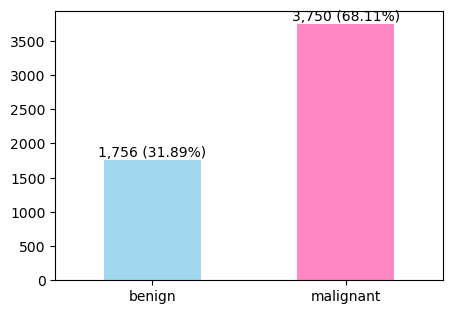

In [5]:
classes = dict(benign=0, malignant=1)
class_names = list(classes.keys())
label_counts = train["label"].value_counts(ascending=True)
ax = label_counts.plot.bar(color=["skyblue", "hotpink"], alpha=0.8,
                           figsize=(5, 3.5))
ax.bar_label(ax.containers[0], padding=0,
             labels=[f"{x:,} ({x/len(train):.2%})" for x in label_counts])
ax.set_xticklabels(["benign", "malignant"], rotation=0);

As we can see that the classes are quite imbalanced. To deal with this, a weighted loss function can be used, but for the scope of this project, I will undersample the dataset, taking 500 both images from both classes. This will help in increasing the speed.
Doing so will upset the train-test split. To counter that, we will undersample the test set as well but without touching the class imbalance. This is done to maintain the real-world nature of the data. A split of 80:20 is maintained.

In [6]:
benign_df=train[train["label"]==0]
mal_df=train[train["label"]==1]
benign_sample=benign_df.sample(n=500, random_state=42)
mal_sample=mal_df.sample(n=500, random_state=42)
train_balanced=pd.concat([benign_sample, mal_sample])

test_set=test.sample(n=250, random_state=42)
train_balanced.shape, test_set.shape

((1000, 5), (250, 5))

In [7]:
device ='cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
class CustomDataset(data.Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __getitem__(self, index):
        filename = self.df.iloc[index]['filename']
        label = self.df.iloc[index]['label']
        img = Image.open(filename).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.df)


In [9]:
MEAN, STD=(0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
IMAGE_SIZE=224
BATCH_SIZE=64

In [10]:
data_transforms = T.Compose([
    T.ToTensor(),
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.Normalize(MEAN, STD)
    
])

In [11]:
train_dataset = CustomDataset(train_balanced, transform=data_transforms)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = CustomDataset(test_set, transform=data_transforms)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [12]:
len(train_loader)

16

In [13]:
len(train_dataset), len(test_dataset)

(1000, 250)

In [14]:
def plot_images(dataloader, num_images=16):
    # Get a batch of images from the dataloader
    data = next(iter(dataloader))
    images, labels = data

    # Generate a grid of images
    img_grid = vutils.make_grid(images[:num_images], nrow=4, padding=2, normalize=True)

    # Convert the image grid to a numpy array and transpose the dimensions
    img_grid = np.transpose(img_grid.cpu().numpy(), (1, 2, 0))

    # Plot the image grid
    plt.figure(figsize=(10,10))
    plt.axis("off")
    plt.imshow(img_grid)
    plt.title("Sample Images")
    plt.show()


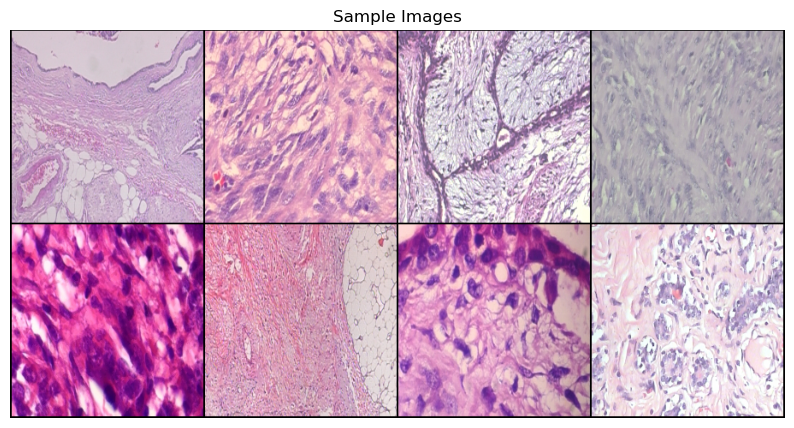

In [15]:
plot_images(train_loader, num_images=8)

In [16]:
class SaveBestModel:
    """ class to save best model while training. """
    def __init__(
        self, best_valid_loss=float('inf')
    ):
        self.best_valid_loss = best_valid_loss
        
    def __call__(
        self, current_valid_loss, 
        epoch, model, optimizer, loss_fn
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss_fn,
                }, '/kaggle/working/best_model.pth')



In [17]:
def save_model(epochs, model, optimizer, loss_fn):
    """
    save final model
    """
    print(f"Saving final model.")
    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss_fn,
                }, '/kaggle/working/final_model.pth')

In [18]:
# def save_plots(train_loss, test_loss, train_acc, test_acc):
#     """
#     Function to save the loss plot to disk.
#     """
#     plt.figure(figsize=(10, 7))
#     plt.plot(
#         train_loss, color='green', linestyle='-', 
#         label='train loss'
#     )
#     plt.plot(
#         test_loss, color='red', linestyle='-', 
#         label='test loss'
#     )
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.legend()
#     plt.savefig('/kaggle/working/loss.png')
    
#     plt.figure(figsize=(10, 7))
#     plt.plot(
#         train_acc, color='green', linestyle='-', 
#         label='train acc'
#     )
#     plt.plot(
#         test_acc, color='red', linestyle='-', 
#         label='test acc'
#     )
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.legend()
#     plt.savefig('/kaggle/working/acc.png')
    
    
    

In [19]:
def save_plots(train_loss, test_loss, train_acc, test_acc):
    """
    Function to save the loss and accuracy plots to disk.
    """
    fig, axs = plt.subplots(2, 2, figsize=(10, 7))
    
    axs[0, 0].plot(
        train_loss, color='green', linestyle='-', 
        label='train loss'
    )
    axs[0, 0].plot(
        test_loss, color='red', linestyle='-', 
        label='test loss'
    )
    axs[0, 0].set_xlabel('Epochs')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].legend()
    
    axs[0, 1].plot(
        train_acc, color='green', linestyle='-', 
        label='train acc'
    )
    axs[0, 1].plot(
        test_acc, color='red', linestyle='-', 
        label='test acc'
    )
    axs[0, 1].set_xlabel('Epochs')
    axs[0, 1].set_ylabel('Accuracy')
    axs[0, 1].legend()
    
    axs[1, 0].plot(
        train_loss, color='green', linestyle='-', 
        label='train loss'
    )
    axs[1, 0].plot(
        test_loss, color='red', linestyle='-', 
        label='test loss'
    )
    axs[1, 0].set_xlabel('Epochs')
    axs[1, 0].set_ylabel('Loss')
    axs[1, 0].legend()
    
    axs[1, 1].plot(
        train_acc, color='blue', linestyle='-', 
        label='train acc'
    )
    axs[1, 1].plot(
        test_acc, color='orange', linestyle='-', 
        label='test acc'
    )
    axs[1, 1].set_xlabel('Epochs')
    axs[1, 1].set_ylabel('Accuracy')
    axs[1, 1].legend()
    
    plt.tight_layout()
    plt.savefig('/kaggle/working/plots.png')


In [20]:
class ResNet18(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.resnet18 = models.resnet18('DEFAULT')
        num_ftrs = self.resnet18.fc.in_features
        self.resnet18.fc = nn.Sequential(
            nn.Linear(num_ftrs, num_ftrs * 2),
            nn.Linear(num_ftrs * 2, num_classes))

    def forward(self, x):
        return self.resnet18(x)


In [21]:
class ShuffleNet(nn.Module):
    def __init__(self, num_classes):
        super(ShuffleNet, self).__init__()
        self.shufflenet = models.shufflenet_v2_x1_0(pretrained=True)
        self.num_classes = num_classes
        self.fc = nn.Linear(1024, num_classes)
        
    def forward(self, x):
        x = self.shufflenet(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x



In [22]:
image_batch, label_batch=next(iter(train_loader))
image, label = image_batch[0] , label_batch[0]
type(label)

torch.Tensor

In [23]:
for batch, (X,y) in enumerate(test_loader):
    X=X.to(device)
    y=y.to(device)
    

In [24]:
device

'cuda'

In [25]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device):
 
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)
#         y_pred = torch.argmax(y_pred, dim=-1)
#         y=y.unsqueeze(1)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [26]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) :
    # Put model in eval mode
    model.eval() 

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [27]:

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) :
 
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }
    
    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        save_best_model(test_loss, epoch, model, optimizer, loss_fn)

    save_model(epochs, model,optimizer, loss_fn)
    save_plots(results["train_loss"], results["test_loss"], results["train_acc"], results["test_acc"])
    # Return the filled results at the end of the epochs
    return results

In [28]:
model = ResNet18(num_classes=2)
optimizer=torch.optim.Adam(params=model.parameters(),
                          lr=0.0001,
                          betas=(0.9, 0.999),
                          weight_decay=0.3)

save_best_model=SaveBestModel()

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6248 | train_acc: 0.6613 | test_loss: 0.5565 | test_acc: 0.7756

Saving best model for epoch: 1

Epoch: 2 | train_loss: 0.4557 | train_acc: 0.8307 | test_loss: 0.4746 | test_acc: 0.7881

Saving best model for epoch: 2

Epoch: 3 | train_loss: 0.3297 | train_acc: 0.9068 | test_loss: 0.4552 | test_acc: 0.7924

Saving best model for epoch: 3

Epoch: 4 | train_loss: 0.2384 | train_acc: 0.9338 | test_loss: 0.4075 | test_acc: 0.8085

Saving best model for epoch: 4

Epoch: 5 | train_loss: 0.1709 | train_acc: 0.9680 | test_loss: 0.3547 | test_acc: 0.8549

Saving best model for epoch: 5

Epoch: 6 | train_loss: 0.1230 | train_acc: 0.9850 | test_loss: 0.3858 | test_acc: 0.8350
Epoch: 7 | train_loss: 0.0889 | train_acc: 0.9951 | test_loss: 0.3585 | test_acc: 0.8440
Epoch: 8 | train_loss: 0.0641 | train_acc: 0.9980 | test_loss: 0.4170 | test_acc: 0.8245
Epoch: 9 | train_loss: 0.0642 | train_acc: 0.9941 | test_loss: 0.3411 | test_acc: 0.8722

Saving best model for epoch: 9

E

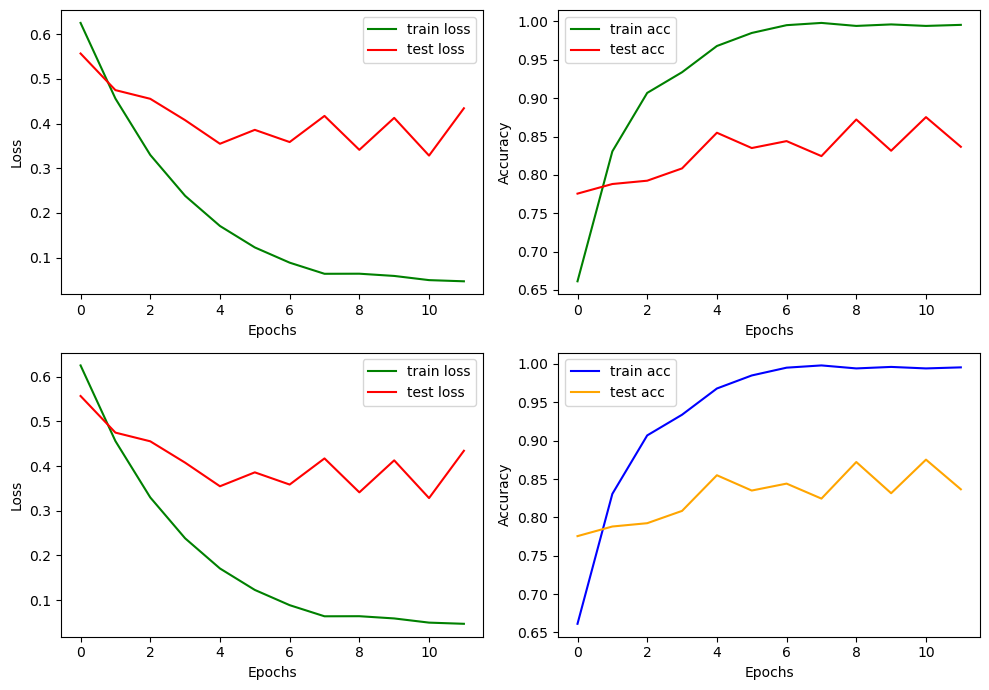

In [29]:
results=train(model=model,
              train_dataloader=train_loader,
              test_dataloader=test_loader,
              optimizer=optimizer,
              loss_fn=F.cross_entropy,
              epochs=12,
              device=device )